# Strategy Description
#### Buy whenever the ratio reaches 0.63 or surpasses it
#### Sell whenever the ratio reaches 0.57 or breaks it
#### Short positions are not allowed
#### Comissions in 1% of the transaction

# Import Libraries

In [395]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use("seaborn")

# Import DataSet

In [396]:
df_ratio=pd.read_excel("PUT_CALL_PARITY_DATA.xlsx")
df_ratio=df_ratio.set_index("Date")
df= yf.download("^GSPC",start="2017-08-21",end="2021-08-10",progress=False)

# Plot the Ratio

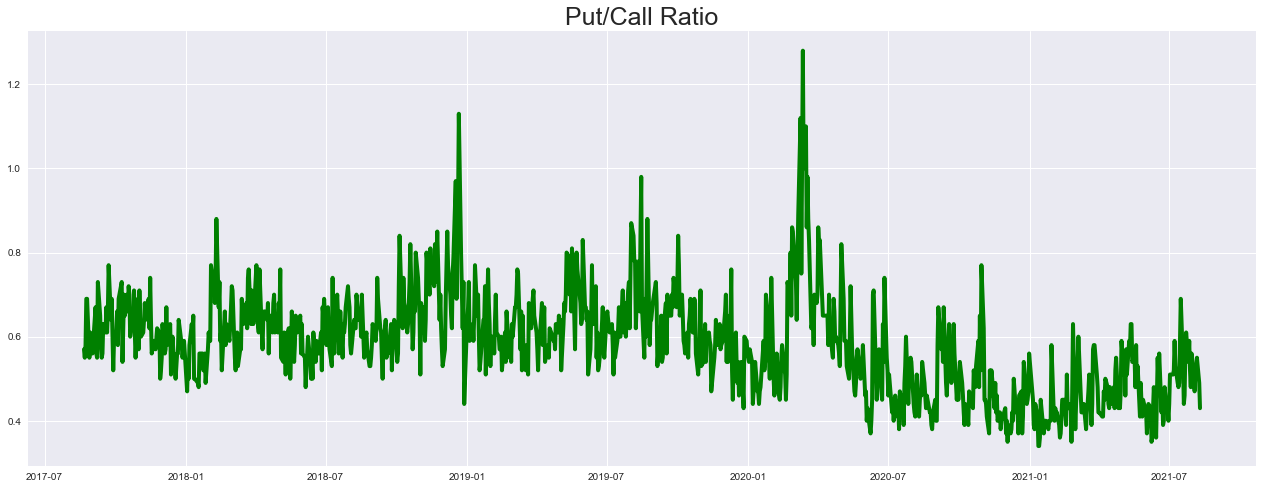

In [397]:
plt.figure(figsize=(22,8))
plt.title("Put/Call Ratio",fontsize=25)
plt.plot(df_ratio["Put/Call_Ratio"],color="green",linewidth=4)

# Plot SP500 Prices

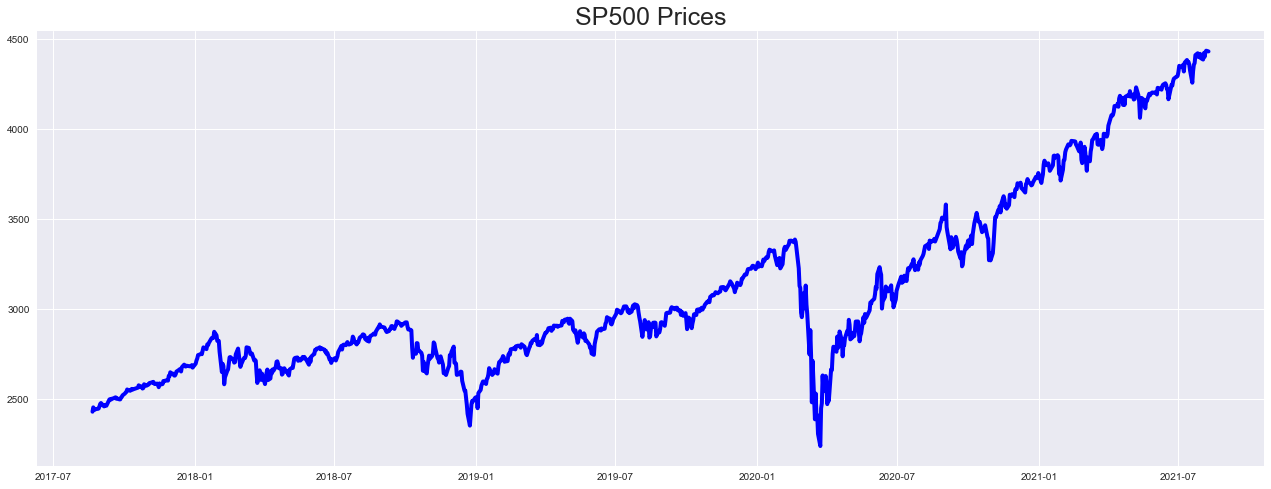

In [398]:
plt.figure(figsize=(22,8))
plt.title("SP500 Prices",fontsize=25)
plt.plot(df["Adj Close"],color="blue",linewidth=4)

# Creating the Strategy

In [399]:
Buy, Sell = [],[]
cash_data_data=[]
df_log=pd.DataFrame()
signal=0
cash=10000
amount=cash
cash_data=[cash]
trades=0
for i in range(len(df["Close"])):
    if df_ratio["Put/Call_Ratio"].iloc[i]>0.63 and signal==0:
        signal+=1
        Buy.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        maximo=math.trunc((cash/(df["Open"].iloc[i+1]+comission)))
        cash-=maximo*(df["Open"].iloc[i+1]+comission)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Buy",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)  
    if df_ratio["Put/Call_Ratio"].iloc[i]<0.57 and signal==1:
        signal=0
        Sell.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        cash+=maximo*(df["Open"].iloc[i+1]+comission)
        cash_data.append(cash)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Sell",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)  
        trades+=1

# Strategy Log

In [400]:
df_log=df_log[::-1]
df_log=df_log.rename(columns={0:"Type",1:"Date",2:"Price",3:"Quantity",4:"Total",5:"Comissions"})
df_log=df_log.set_index("Date")
df_log

,Type,Price,Quantity,Total,Comissions
Date,,,,,
2017-08-25,Buy,2444.719971,4,9778.879883,24.447200
2017-08-29,Sell,2431.939941,4,9727.759766,24.319399
2017-09-06,Buy,2463.830078,3,7391.490234,24.638301
2017-09-07,Sell,2468.060059,3,7404.180176,24.680601
2017-09-11,Buy,2474.520020,3,7423.560059,24.745200
...,...,...,...,...,...
2020-10-30,Sell,3293.590088,3,9880.770264,32.935901
2020-11-02,Buy,3296.199951,3,9888.599854,32.962000
2020-11-04,Sell,3406.459961,3,10219.379883,34.064600


In [401]:
if df_log.iloc[-1]["Type"]=="Buy":
    df_log=df_log.iloc[:-1]
    Buy=Buy[:-1]

# Performace Chart

In [402]:
buy_hold=[]
datas_buy_hold=[]
shares=df_log["Quantity"][0]
for a in range(len(df)):
    buy_hold.append(df["Close"].iloc[a]*shares)
    datas_buy_hold.append(df.index[a])
minimo_buy_hold=min(buy_hold)
buy_hold=pd.DataFrame(pd.Series(buy_hold))
datas_buy_hold=pd.DataFrame(pd.Series(datas_buy_hold))
buy_hold["Datas"]=datas_buy_hold
buy_hold=buy_hold.set_index("Datas")

In [403]:
min_budget=min(cash_data)
cash_data=pd.DataFrame(pd.Series(cash_data))
t_f=df_log["Type"]=="Sell"
cash_data_data=df_log[t_f]
cash_data_data=cash_data_data.index
cash_data_data=pd.DataFrame(pd.Series(cash_data_data))
cash_data["Dates"]=cash_data_data
cash_data=cash_data.set_index("Dates")
cash_data=cash_data.shift(-1) 

# Strategy x Buy & Hold

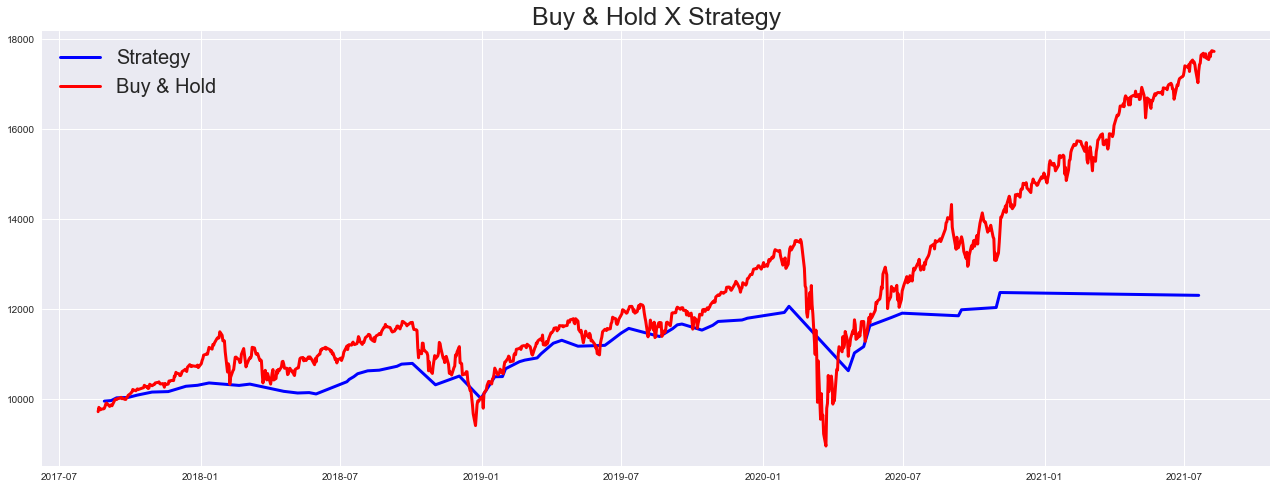

In [404]:
plt.figure(figsize=(22,8))
plt.plot(cash_data,color="blue",label="Strategy",linewidth=3)
plt.plot(buy_hold,color="red",label="Buy & Hold",linewidth=3)
plt.title("Buy & Hold X Strategy",fontsize=25)
plt.legend(fontsize=20)
plt.show()

# Signal Plot

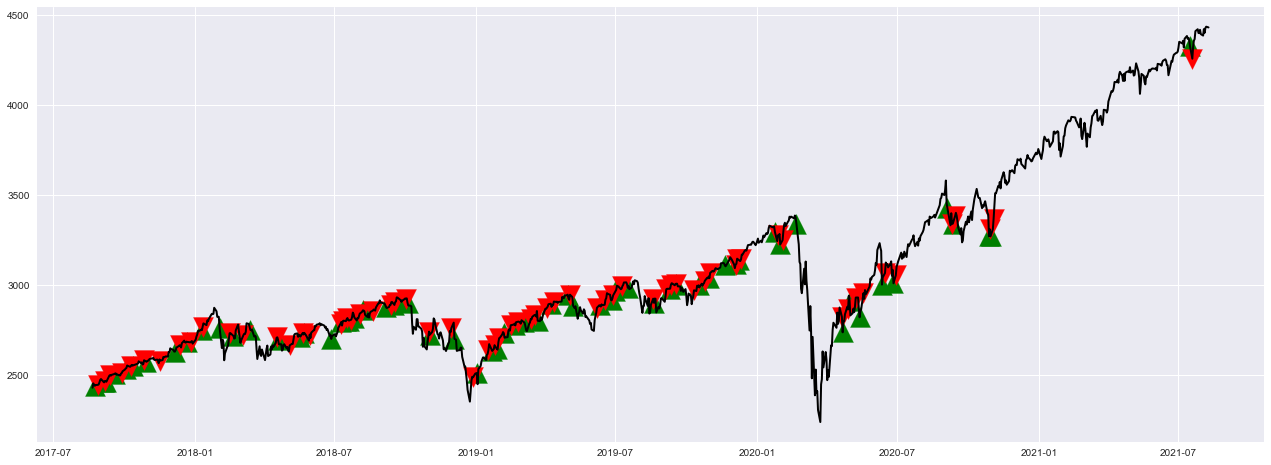

In [405]:
plt.figure(figsize=(22,8))
plt.scatter(df.iloc[Buy].index, df.iloc[Buy]["Adj Close"], marker="^", color="green",s=400)
plt.scatter(df.iloc[Sell].index, df.iloc[Sell]["Adj Close"], marker="v", color="red",s=400)
plt.plot(df["Adj Close"], label="Price", color="k",linewidth =2)

# Final Results

In [406]:
print(f"Period: {df.index.day[0]}/{df.index.month[0]}/{df.index.year[0]} - {df.index.day[-1]}/{df.index.month[-1]}/{df.index.year[-1]}")
print("-="*15)
strategy_return=cash_data.iloc[-2][0]/cash_data.iloc[0][0].round(2)
print(f"Strategy Total Return: {(cash_data.iloc[-2][0]/cash_data.iloc[0][0]).round(2)*100}%")
x=df["Close"][-1]/df["Close"][0]
print(f"Buy & Hold Total Return {(x*100).round(2)}% ")
print("-="*15)
print(f"Strategy Annual Return: {(((1+strategy_return)**(252/len(df))-1)*100).round(2)}%")
print(f"Buy & Hold Annual Return: {(((1+x)**(252/len(df))-1)*100).round(2)}%")
print("-="*15)
print(f"Trades: {trades}")
print(f"Trades/Year: {trades/(len(df)/252)}")
print("-="*15)
print(f"Maximum Strategy drawdown: {(((min_budget-amount)/amount)*100)}%")
print(f"Maximum Buy & Hold drawdown: {(((min(buy_hold[0])-amount)/amount)*100)}%")

Period: 21/8/2017 - 9/8/2021
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Strategy Total Return: 124.0%
Buy & Hold Total Return 182.52% 
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Strategy Annual Return: 22.51%
Buy & Hold Annual Return: 29.95%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Trades: 65
Trades/Year: 16.396396396396394
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Maximum Strategy drawdown: -0.5163131835937566%
Maximum Buy & Hold drawdown: -10.50400390625%


# Sharpe Index

In [407]:
print(f"Strategy Sharpe Index: {(((1+strategy_return)**(252/len(df))-1)*100)/(-1*((min_budget-amount)/amount)*100)}")
print(f"Market Sharpe Index: {(((1+x)**(252/len(df))-1)*100).round(2)/((-1*(min(buy_hold[0])-amount)/amount)*100)} ")

Strategy Sharpe Index: 43.60497498621003
Market Sharpe Index: 2.8512936845139034 


# Hit Ratio

In [413]:
gain=0
loss=0
for t in range(len(df_log["Total"])):
    if df_log["Type"].iloc[t]=="Sell" and df_log["Total"].iloc[t]>df_log["Total"].iloc[t-1]:
        gain+=1
    if df_log["Type"].iloc[t]=="Sell" and df_log["Total"].iloc[t]<df_log["Total"].iloc[t-1]:
        loss+=1
print(f"Hit Ratio: {gain/(gain+loss)*100}%")

Hit Ratio: 80.0%
